In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
df = pl.read_parquet('/work/resnet152_sweep_data.parquet')
# df = pl.read_parquet('/work/resnet18_sweep_data.parquet')

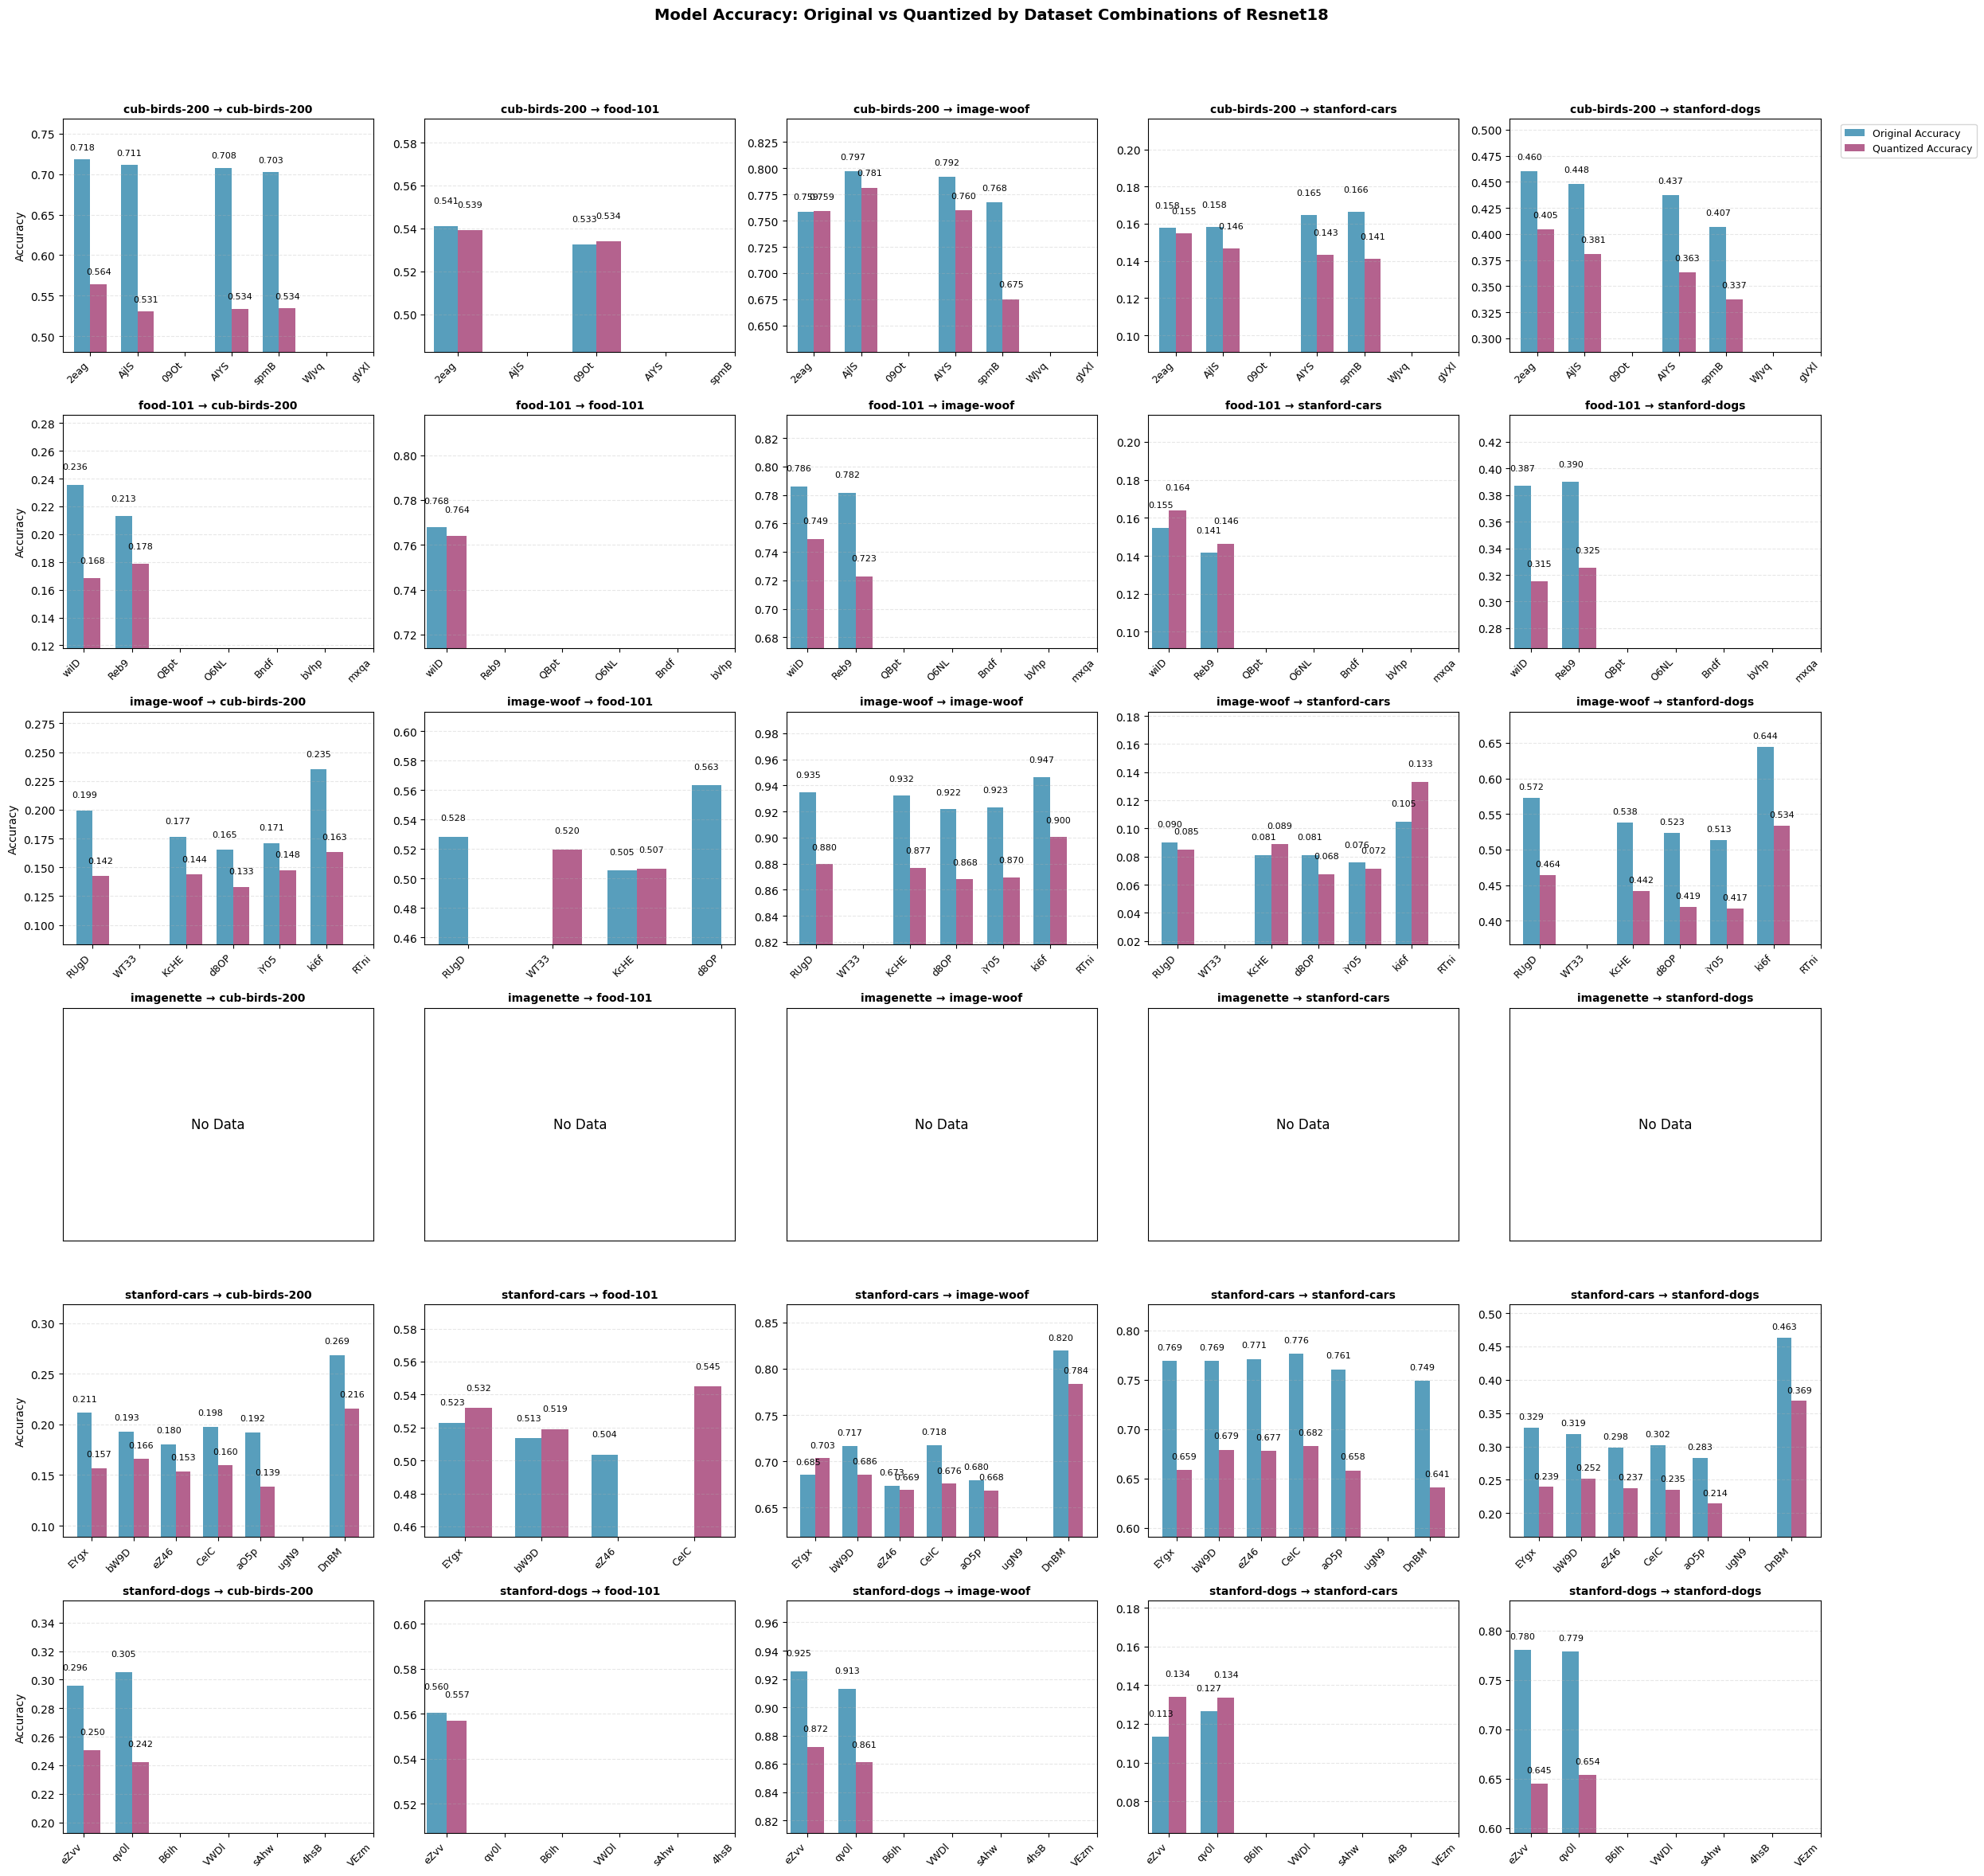

In [8]:
df_clean = df.with_columns((pl.col('model_dataset') + ' → ' + pl.col('training_dataset')).alias('group'))

training_datasets = sorted(df_clean['training_dataset'].unique().to_list())
model_datasets = sorted(df_clean['model_dataset'].unique().to_list())

groups = []
for train_ds in training_datasets:
    for model_ds in model_datasets:
        group_name = f"{train_ds} → {model_ds}"
        if len(df_clean.filter(pl.col('group') == group_name)) > 0:
            groups.append(group_name)

n_groups = len(groups)
n_train_datasets = len(training_datasets)
n_model_datasets = len(model_datasets)

fig, axes = plt.subplots(n_train_datasets, n_model_datasets, figsize=(5 * n_model_datasets, 4 * n_train_datasets))

if n_train_datasets == 1 and n_model_datasets == 1:
    axes = [[axes]]
elif n_train_datasets == 1:
    axes = [axes]
elif n_model_datasets == 1:
    axes = [[ax] for ax in axes]

colors = ['#2E86AB', '#A23B72']
bar_width = 0.35

for i, train_ds in enumerate(training_datasets):
    for j, model_ds in enumerate(model_datasets):
        ax = axes[i][j]
        group_name = f"{train_ds} → {model_ds}"
        group_data = df_clean.filter(pl.col('group') == group_name).sort('model_name')
        
        if len(group_data) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{train_ds} → {model_ds}", fontsize=10, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        models = group_data['model_name'].to_list()
        original_acc = group_data['original_accuracy'].to_list()
        quantized_acc = group_data['quantized_accuracy'].to_list()
        
        n_models = len(models)
        model_positions = np.arange(n_models)
        
        mask_orig = [v is not None for v in original_acc]
        mask_quant = [v is not None for v in quantized_acc]
        
        orig_positions = [pos - bar_width/2 for pos, m in zip(model_positions, mask_orig) if m]
        orig_values = [v for v, m in zip(original_acc, mask_orig) if m]
        
        quant_positions = [pos + bar_width/2 for pos, m in zip(model_positions, mask_quant) if m]
        quant_values = [v for v, m in zip(quantized_acc, mask_quant) if m]
        
        bars1 = ax.bar(orig_positions, orig_values, bar_width, 
                       label='Original Accuracy', color=colors[0], alpha=0.8)
        bars2 = ax.bar(quant_positions, quant_values, bar_width,
                       label='Quantized Accuracy', color=colors[1], alpha=0.8)
        
        for bar, value in zip(bars1, orig_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        
        for bar, value in zip(bars2, quant_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        
        model_labels = [model.split('-')[-1] for model in models]
        ax.set_xticks(model_positions)
        ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
        ax.set_title(f"{train_ds} → {model_ds}", fontsize=10, fontweight='bold')
        
        if j == 0:
            ax.set_ylabel('Accuracy', fontsize=10)
        if i == 0 and j == n_model_datasets - 1:
            ax.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        
        all_valid_values = [v for v in orig_values + quant_values if not math.isnan(v)]
        if all_valid_values:
            y_min = min(all_valid_values) - 0.05 if min(all_valid_values) - 0.05 > 0 else 0
            y_max = max(all_valid_values) + 0.05
            ax.set_ylim(y_min, y_max)

fig.suptitle('Model Accuracy: Original vs Quantized by Dataset Combinations of Resnet18', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("resnet125.png", dpi=600)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7dd8a54b-b654-4e26-9ba8-1dc7a02da688' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>